In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyscf import scf, gto

plt.style.use(["seaborn"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# s-Funktionen 

## H2 

In [2]:
basis = "3-21++g"
H2_1 = gto.Mole(atom="H 0.0 0.0 0.0\nH 1.0 0.0 0.0", basis=basis)
H2_1.build()
H2_2 = gto.Mole(atom="H 0.0 0.0 0.0\nH 0.0 1.0 0.0", basis=basis)
H2_2.build()

### Overlap 

0.0


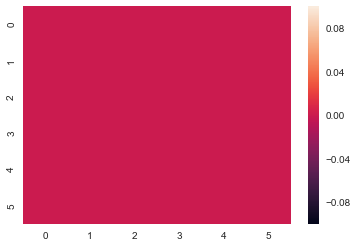

In [3]:
sH2_1 = scf.hf.get_ovlp(H2_1)
sH2_2 = scf.hf.get_ovlp(H2_2)

print(np.mean(np.abs(sH2_1 - sH2_2)))

sns.heatmap(sH2_1-sH2_2)
plt.show()

### Density 

7.128629284092192e-17


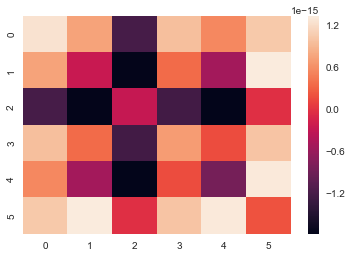

In [4]:
def calculate_density(mol):
    mf = scf.RHF(mol)
    mf.verbose = 0
    mf.scf()
    return mf.make_rdm1()

pH2_1 = calculate_density(H2_1)
pH2_2 = calculate_density(H2_2)
print(np.mean(pH2_1 - pH2_2))

sns.heatmap(pH2_1 - pH2_2)
plt.show()

# Ausgangsmolecule

in x direction

In [5]:
mol = gto.Mole()
mol.atom = """
F 0.0 0.0 0.0
H 1.0 0.0 0.0
"""
mol.basis = "sto-3g"

mol.build()

In [6]:
s = scf.hf.get_ovlp(mol)
print(s)

[[1.         0.23798988 0.         0.         0.         0.04057559]
 [0.23798988 1.         0.         0.         0.         0.39514046]
 [0.         0.         1.         0.         0.         0.31965214]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.04057559 0.39514046 0.31965214 0.         0.         1.        ]]


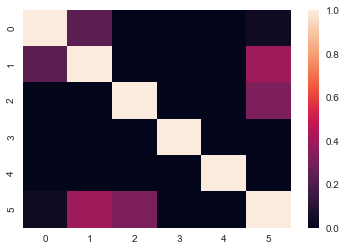

In [7]:
sns.heatmap(s)
plt.show()

# 90 ° Rotation 
in y direction

In [18]:
1/np.sqrt(2)

0.7071067811865475

In [19]:
mol90 = gto.Mole()
mol90.atom = """
F 0.0 0.0 0.0
H 0.0 1.0 0.0
"""
mol90.basis = "sto-3g"
mol90.build()

s90 = scf.hf.get_ovlp(mol90)
print(s90)

[[1.         0.23798988 0.         0.         0.         0.04057559]
 [0.23798988 1.         0.         0.         0.         0.39514046]
 [0.         0.         1.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.31965214]
 [0.         0.         0.         0.         1.         0.        ]
 [0.04057559 0.39514046 0.         0.31965214 0.         1.        ]]


In [20]:
np.set_printoptions(precision=5, suppress=True)
print(s - s90)

[[ 0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       0.       0.31965]
 [ 0.       0.       0.       0.       0.      -0.31965]
 [ 0.       0.       0.       0.       0.       0.     ]
 [ 0.       0.       0.31965 -0.31965  0.       0.     ]]


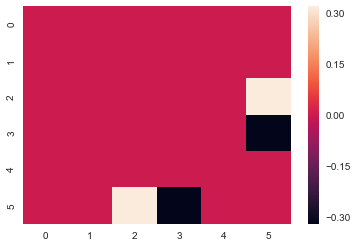

In [21]:
sns.heatmap((s - s90))

0.19670692001957413


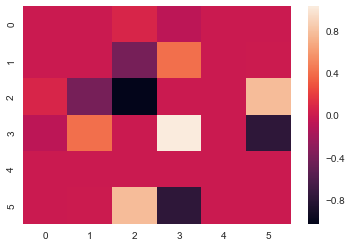

In [22]:
pMol = calculate_density(mol)
pMol90 = calculate_density(mol90)
print(np.mean(np.abs(pMol - pMol90)))

sns.heatmap(pMol - pMol90)

# Rotation of the Basis 

## Rotation Matrix 

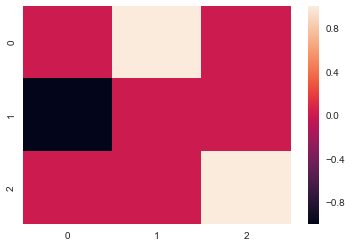

In [23]:
def rotation_z(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

R90 = rotation_z(-np.pi/2)
sns.heatmap(R90)

## OverlapMatrix
over lap of mol basis to basis rotated 90 degree around z axis. Thus pz is not changed

In [25]:
print(s90)
print(R90)

[[1.      0.23799 0.      0.      0.      0.04058]
 [0.23799 1.      0.      0.      0.      0.39514]
 [0.      0.      1.      0.      0.      0.     ]
 [0.      0.      0.      1.      0.      0.31965]
 [0.      0.      0.      0.      1.      0.     ]
 [0.04058 0.39514 0.      0.31965 0.      1.     ]]
[[ 0.  1.  0.]
 [-1.  0.  0.]
 [ 0.  0.  1.]]


In [26]:
quantum_number = [
    [1, 0, 0], # F 1s
    [2, 0, 0], # F 2s
    [2, 1, 0], # F 2px
    [2, 1, 1], # F 2py
    [2, 1, 2], # F 2pz
    [1, 0, 0], # H 1s   
]

In [29]:
def make_transformation_overlap(R,S):
    
    Q = S.copy()
    
    for i, lhs in enumerate(quantum_number): 
        for j, rhs in enumerate(quantum_number):
            ni, nj = lhs[0], rhs[0]
            li, lj = lhs[1], rhs[1]
            mi, mj = lhs[2], rhs[2]
            
            # if li = 0 no ration was performed, no change necessary
            if li > 0:
                new_overlap = 0
                
                if li == 1:
                    # rotated orbital phi_tilde_i = sum_m_prime R(m, m_prime) phi_k 
                    for m_prime, k in enumerate(range(i - mi, i - mi + 3)):
                        new_overlap += S[k, j] * R[mi, m_prime]

                elif li == 2:
                    # use higher order rotations
                    raise IndexError("d-orbitals not implemented")
            
    return Q

q90 = make_transformation_overlap(R90, s)

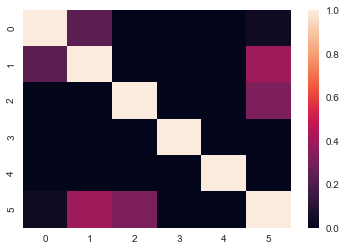

In [35]:
sns.heatmap(q90)

In [36]:
s_trans = q90.T s @ q90

print(np.mean(np.abs(s_trans-s90)))
sns.heatmap(s_trans-s)

SyntaxError: invalid syntax (<ipython-input-36-bc3a005e76a2>, line 1)